Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10

Библиотеки: [Python, Tensorflow]

In [2]:
import tensorflow as tf

gpu_device = tf.config.experimental.list_physical_devices('GPU')
if gpu_device:
    tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

### Загрузка и подготовка данных.

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'обучающие примеры')
print(X_test.shape[0], 'тестовые примеры')

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train = X_train / 255
X_test = X_test / 255

X_train shape: (50000, 32, 32, 3)
50000 обучающие примеры
10000 тестовые примеры


In [5]:
classes = [
    'самолет', 
    'автомобиль', 
    'птица', 
    'кот', 
    'олень', 
    'собака', 
    'лягушка', 
    'лошадь', 
    'корабль', 
    'грузовик'
]

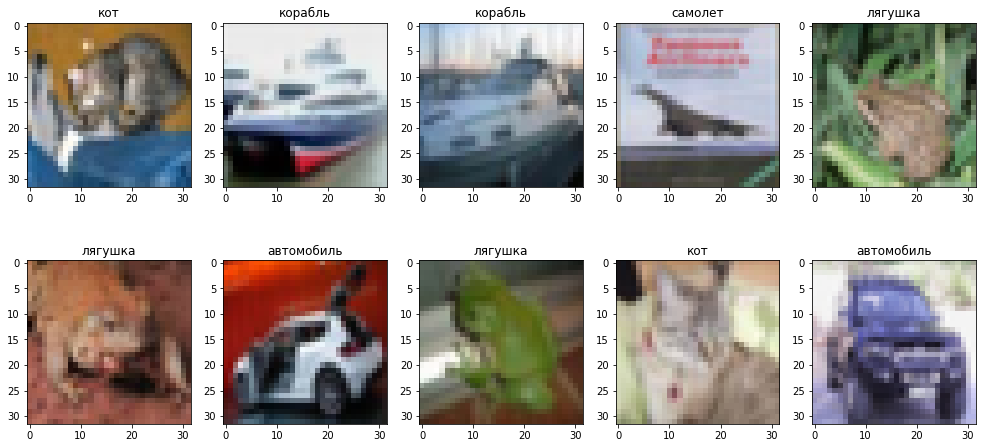

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(17, 8))

samples = range(10)

for idx in samples:
    pos = ax[idx//5, idx%5]
    pos.imshow(X_test[idx])
    pos.set_title(classes[np.argmax(y_test[idx, :])])
plt.show()

### Расширение датасета.

Для расширения датасета будут производиться случайные преобразования изображений, такие как поворот, отражение, сдвиги по осям и т.д. Благодаря таким преобразованиям, модели на вход не будет подаваться одно и то же изображение дважды. Этот трюк позволяет до определенного момента бороться с переобучением. Модель не будет запоминать картинки, а будет стремиться выделять более обобщающие признаки. Тем не менее переобучение неминуемо, т.к. все изображения сгенерированы из одного набора данных.

In [7]:
datagen = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=3, 
    height_shift_range=3, 
    zoom_range=(0.95, 1.05), 
    fill_mode='nearest', 
    horizontal_flip=True, 
    vertical_flip=True
)

train_gen = datagen.flow(X_train, 
                         y_train,
                         batch_size=64)

Визуализация преобразованных изображений.

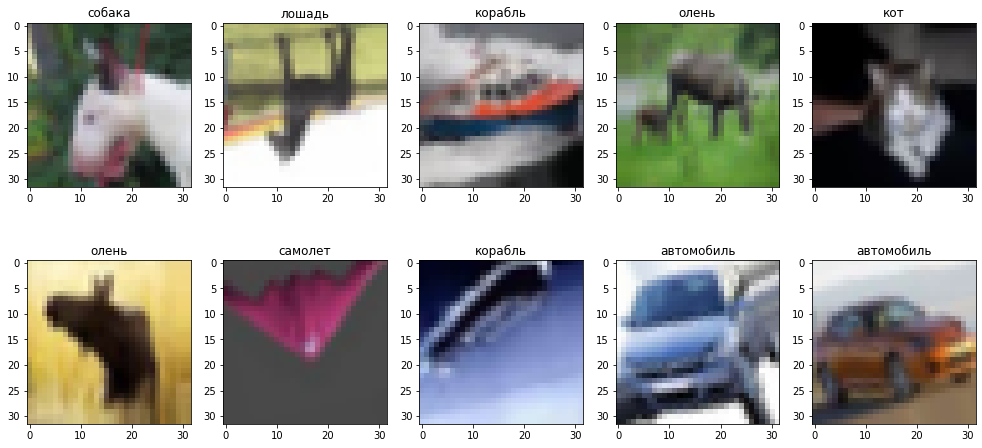

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(17, 8))

indices = range(10)
imgs, labels = train_gen[0]

for idx in indices:
    pos = ax[idx//5, idx%5]
    pos.imshow(imgs[idx])
    pos.set_title(classes[np.argmax(labels[idx])])
plt.show()

### Построение модели.

In [9]:
def IC_block(prev_layer, dropout=0):
    x = layers.BatchNormalization()(prev_layer)
    x = layers.Dropout(dropout)(x)
    return x
    

def conv_block(n_filters, prev_layer, dropout=0, random_state=None):
    '''
    Сверточный блок:
    2 сверточных слоя (3, 3) с ф-цией активации 'relu'
    
    '''
    tf.random.set_seed(random_state)
    x = layers.Conv2D(n_filters, (3, 3), padding='same')(prev_layer)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(n_filters, (3, 3))(x)
    x = layers.Activation('relu')(x)
    
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = IC_block(x, dropout=dropout)
    return x

In [11]:
inputs = layers.Input(shape=X_train.shape[1:])

# Conv (32, 32, 3) --> (15, 15, 32)
x = conv_block(32, inputs, dropout=0.2)
# Conv (15, 15, 32) --> (6, 6, 64)
x = conv_block(64, x, dropout=0.2)
# Conv (6, 6, 64) --> (2, 2, 128)
x = conv_block(128, x, dropout=0.2)

# Pooling (2, 2, 128) --> (128)
x = layers.GlobalAveragePooling2D()(x)

# FC (128) --> (1024)
x = layers.Dense(1024)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

# Output 
outputs = layers.Dense(10)(x)
outputs = layers.Activation('softmax')(outputs)

model = Model(inputs, outputs)
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 32)        128 

### Обучение модели.

Обучение будет длиться дольше, т.к. мы расширили датасет путем случайных преобразований изображений. Обучение будем проводить в течение 100 эпох с понижением learning rate после 50-ой эпохи.

Добавим соответствующий callback и функцию для него.

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch):
    lr = 1e-3
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(0.04 * (10 - epoch))   


callback = LearningRateScheduler(scheduler)

In [14]:
train_eval = model.evaluate(X_train, y_train)
valid_eval = model.evaluate(X_test, y_test)

history = model.fit(train_gen, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    callbacks=[callback], 
#                     max_queue_size=64, 
#                     workers=8, 
#                     use_multiprocessing=True
                   )

results = {}

results['loss'] = train_eval[:1] + history.history['loss']
results['val_loss'] = valid_eval[:1] + history.history['val_loss']
results['accuracy'] = train_eval[1:] + history.history['accuracy']
results['val_accuracy'] = valid_eval[1:] + history.history['val_accuracy']

313/313 [==============================] - 1s 4ms/step - loss: 2.3027 - accuracy: 0.1000
Epoch 1/100
782/782 [==============================] - 28s 35ms/step - loss: 1.6683 - accuracy: 0.3846 - val_loss: 1.4971 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 2/100
782/782 [==============================] - 29s 37ms/step - loss: 1.3674 - accuracy: 0.5052 - val_loss: 1.3994 - val_accuracy: 0.5041 - lr: 0.0010
Epoch 3/100
782/782 [==============================] - 29s 37ms/step - loss: 1.2245 - accuracy: 0.5635 - val_loss: 1.2699 - val_accuracy: 0.5675 - lr: 0.0010
Epoch 4/100
782/782 [==============================] - 28s 35ms/step - loss: 1.1479 - accuracy: 0.5910 - val_loss: 1.1627 - val_accuracy: 0.5929 - lr: 0.0010
Epoch 5/100
782/782 [==============================] - 28s 36ms/step - loss: 1.0852 - accuracy: 0.6147 - val_loss: 1.1740 - val_accuracy: 0.5939 - lr: 0.0010
Epoch 6/100
782/782 [==============================] - 27s 35ms/step - loss: 1.0430 - accuracy: 0.6345 - val_loss: 1.1898

### Графики потерь и метрики.

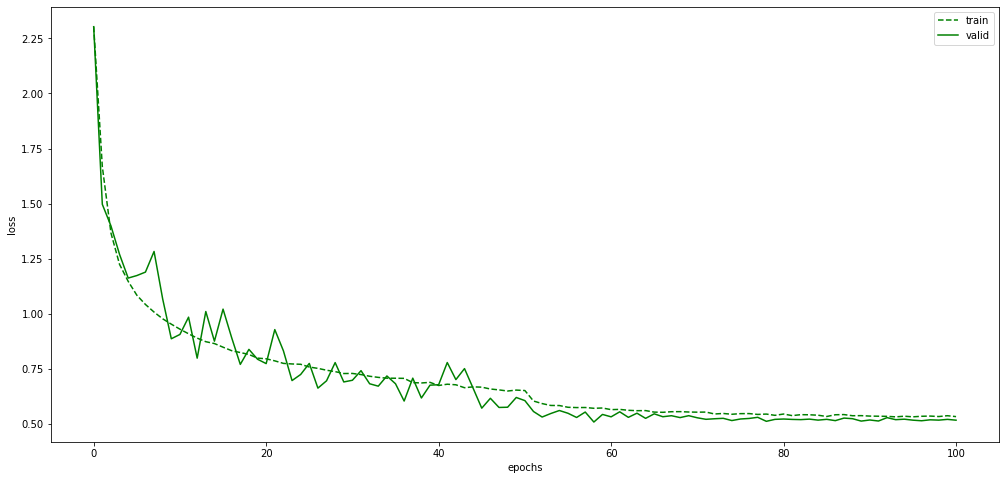

In [15]:
plt.figure(figsize=(17, 8))
plt.plot(*zip(*enumerate(results['loss'])), c='g', linestyle='--', label='train')
plt.plot(*zip(*enumerate(results['val_loss'])), c='g', linestyle='-', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

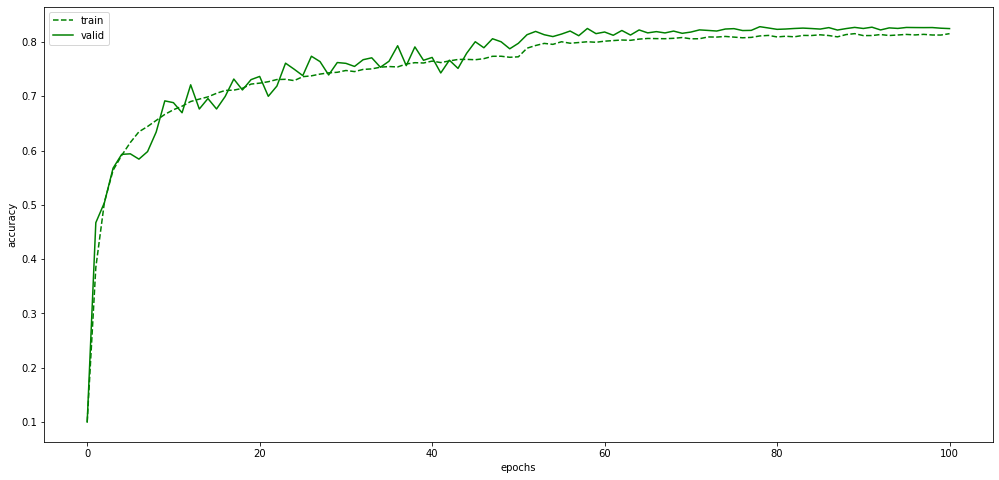

In [16]:
plt.figure(figsize=(17, 8))
plt.plot(*zip(*enumerate(results['accuracy'])), c='g', linestyle='--', label='train')
plt.plot(*zip(*enumerate(results['val_accuracy'])), c='g', linestyle='-', label='valid')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()